In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
import os

import acquire as a
import explore as e
import prepare as p 
import wrangle as w

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from env import host, username, password

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
7. Which lessons are least accessed?
8. Anything else I should be aware of?

In [2]:
df = w.wrangle_logs()
df.head()

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name
date,,,,,,,,,,,,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:55:03,097-105-019-061.biz.spectrum.com
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:56:02,097-105-019-061.biz.spectrum.com
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:56:05,097-105-019-061.biz.spectrum.com
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:56:06,097-105-019-061.biz.spectrum.com
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0,2018-01-26 09:56:24,097-105-019-061.biz.spectrum.com


In [3]:
# Deep copy of df
original_df = df.copy()

In [4]:
df.shape

(900223, 16)

In [5]:
df.isna().sum()

time               0
path               1
user_id            0
cohort_id      52893
ip                 0
id             52893
name           52893
slack          52893
start_date     52893
end_date       52893
created_at     52893
updated_at     52893
deleted_at    900223
program_id     52893
datetime           0
ip_name        63544
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 to 2021-04-21
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        900223 non-null  object        
 1   path        900222 non-null  object        
 2   user_id     900223 non-null  int64         
 3   cohort_id   847330 non-null  float64       
 4   ip          900223 non-null  object        
 5   id          847330 non-null  float64       
 6   name        847330 non-null  object        
 7   slack       847330 non-null  object        
 8   start_date  847330 non-null  object        
 9   end_date    847330 non-null  object        
 10  created_at  847330 non-null  object        
 11  updated_at  847330 non-null  object        
 12  deleted_at  0 non-null       float64       
 13  program_id  847330 non-null  float64       
 14  datetime    900223 non-null  datetime64[ns]
 15  ip_name     836679 non-null  object

In [7]:
nada = df[df['cohort_id'].isna()]

In [8]:
nada.head()

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name
date,,,,,,,,,,,,,,,,
2018-01-26,16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-26 16:46:16,097-105-019-061.biz.spectrum.com
2018-01-26,16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-26 16:46:24,097-105-019-061.biz.spectrum.com
2018-01-26,17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-26 17:54:24,097-105-019-061.biz.spectrum.com
2018-01-26,18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-26 18:32:03,097-105-019-061.biz.spectrum.com
2018-01-26,18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-26 18:32:17,097-105-019-061.biz.spectrum.com


# 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


In [9]:
df['year'] = df.datetime.dt.year

In [10]:
twenty_zero_nine = df[df['year'] == 2019]

In [11]:
df.path.value_counts()

/                           50313
search/search_index.json    19519
javascript-i                18983
toc                         18297
java-iii                    13733
                            ...  
studentx                        1
mysql//sample-database          1
bayes-capstones                 1
bayes-capstones/html            1
joins                           1
Name: path, Length: 2313, dtype: int64

In [12]:
df = df.set_index(df.datetime)

In [13]:
df.head()

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name,year
datetime,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:55:03,097-105-019-061.biz.spectrum.com,2018
2018-01-26 09:56:02,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:56:02,097-105-019-061.biz.spectrum.com,2018
2018-01-26 09:56:05,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:56:05,097-105-019-061.biz.spectrum.com,2018
2018-01-26 09:56:06,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0,2018-01-26 09:56:06,097-105-019-061.biz.spectrum.com,2018
2018-01-26 09:56:24,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0,2018-01-26 09:56:24,097-105-019-061.biz.spectrum.com,2018


In [14]:
df.program_id.value_counts()

2.0    713365
3.0    103412
1.0     30548
4.0         5
Name: program_id, dtype: int64

In [15]:
df[df['program_id'] == 4]

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name,year
datetime,,,,,,,,,,,,,,,,,
2018-03-22 19:01:49,19:01:49,/,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,4.0,2018-03-22 19:01:49,207-68-209-17.nctc.net,2018
2018-03-22 19:01:54,19:01:54,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,4.0,2018-03-22 19:01:54,207-68-209-17.nctc.net,2018
2018-03-22 19:01:54,19:01:54,content/html-css/gitbook/images/favicon.ico,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,4.0,2018-03-22 19:01:54,207-68-209-17.nctc.net,2018
2018-03-22 19:02:47,19:02:47,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,4.0,2018-03-22 19:02:47,207-68-209-17.nctc.net,2018
2018-03-22 19:02:52,19:02:52,content/html-css/introduction.html,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,4.0,2018-03-22 19:02:52,207-68-209-17.nctc.net,2018


In [16]:
daily = df.path.resample('D').count()
weekly = df.path.resample('W').count()

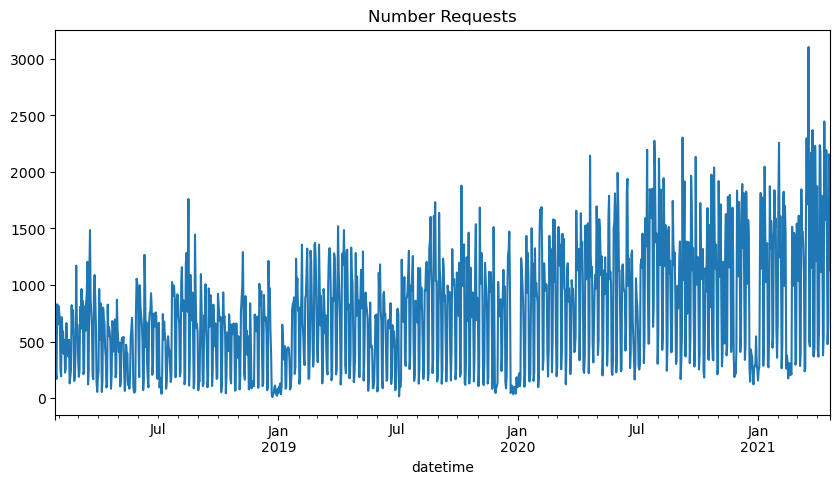

In [17]:
plt.figure(figsize=(10,5))
daily.plot()
plt.title('Number Requests')
plt.show()

In [18]:
daily_2019 = twenty_zero_nine.path.resample('D').count()

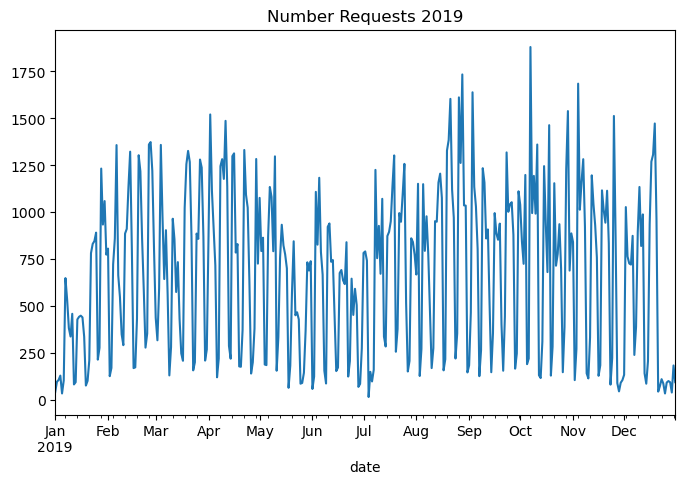

In [19]:
plt.figure(figsize=(8,5))
daily_2019.plot()
plt.title('Number Requests 2019')
plt.show()

In [20]:
slash = twenty_zero_nine[twenty_zero_nine['path'] == '/']

In [21]:
# 13k slash paths
twenty_zero_nine.path.value_counts()

/                               13143
search/search_index.json         6121
toc                              4972
javascript-i                     4707
html-css                         3632
                                ...  
appendix/cls/2-listing-files        1
web-design/ux/layout/.json          1
extra-features/json-response        1
extra-features/file-upload          1
login.aspx                          1
Name: path, Length: 1473, dtype: int64

In [22]:
slash.datetime.idxmin(), slash.datetime.idxmax()


(Timestamp('2019-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [23]:
# Program ID 1 is Web Dev
df[df['program_id'] == 1]['path'].value_counts().head(40)

/                                                                            1681
index.html                                                                   1011
javascript-i                                                                  736
html-css                                                                      542
spring                                                                        501
java-iii                                                                      479
java-ii                                                                       454
java-i                                                                        444
javascript-ii                                                                 429
appendix                                                                      409
jquery                                                                        344
mysql                                                                         284
content/html-css

In [24]:
# Program ID 2 is Web Dev
df[df['program_id'] == 2]['path'].value_counts().head(10)

/                           35814
javascript-i                17457
toc                         17428
search/search_index.json    15212
java-iii                    12683
html-css                    12569
java-ii                     11719
spring                      11376
jquery                      10693
mysql                       10318
Name: path, dtype: int64

In [25]:
# Program ID 3 is DS
df[df['program_id'] == 3]['path'].value_counts().head(15)

/                                                    8358
search/search_index.json                             2203
classification/overview                              1785
1-fundamentals/modern-data-scientist.jpg             1655
1-fundamentals/AI-ML-DL-timeline.jpg                 1651
1-fundamentals/1.1-intro-to-data-science             1633
classification/scale_features_or_not.svg             1590
fundamentals/AI-ML-DL-timeline.jpg                   1443
fundamentals/modern-data-scientist.jpg               1438
sql/mysql-overview                                   1424
fundamentals/intro-to-data-science                   1413
6-regression/1-overview                              1124
anomaly-detection/AnomalyDetectionCartoon.jpeg        829
anomaly-detection/overview                            804
10-anomaly-detection/AnomalyDetectionCartoon.jpeg     754
Name: path, dtype: int64

**Program ID:**

1 == WEB DEV

2 == WEB DEV

3 == DS

4 == no idea

In [26]:
web_dev = twenty_zero_nine[(twenty_zero_nine['program_id'] == 1) | (twenty_zero_nine['program_id'] == 2)]
ds = twenty_zero_nine[twenty_zero_nine['program_id'] == 3]

In [27]:
# Removing Staff from cohorts
ds = ds[ds['name'] != 'Staff']
web_dev = web_dev[web_dev['name'] != 'Staff']


In [28]:
# Daily access from DS and WD
ds_daily = ds.path.resample('d').count()
web_dev_daily = web_dev.path.resample('d').count()

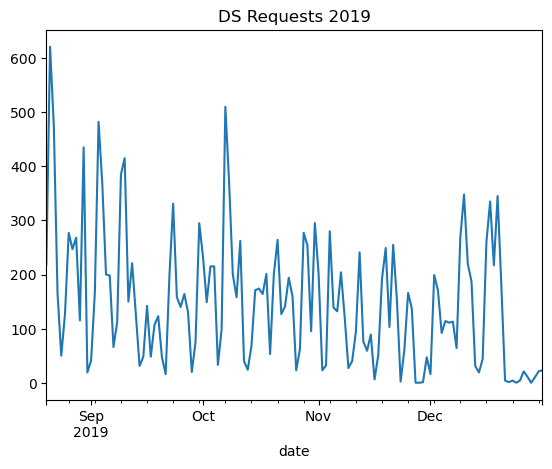

In [29]:
# DS plot
ds_daily.plot()
plt.title('DS Requests 2019')
plt.show()

In [30]:
# DS students accessing Java stuff
ds_to_wd = ds[ds['path'].str.contains('java')].resample('d').count()
ds_to_wd

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name,year
date,,,,,,,,,,,,,,,,,
2019-09-23,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
2019-09-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-09-25,10,10,10,10,10,10,10,10,10,10,10,10,0,10,10,10,10
2019-09-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-09-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-09-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-09-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-09-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-10-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# WD students accessing data-scientist stuff
wd_to_ds = web_dev[web_dev['path'].str.contains('data-scientist')].resample('w').count()
wd_to_ds

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name,year
date,,,,,,,,,,,,,,,,,
2019-08-25,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4
2019-09-01,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4
2019-09-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-09-15,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3
2019-09-22,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,2,3
2019-09-29,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
2019-10-06,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,0,2
2019-10-13,6,6,6,6,6,6,6,6,6,6,6,6,0,6,6,5,6
2019-10-20,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,2,3


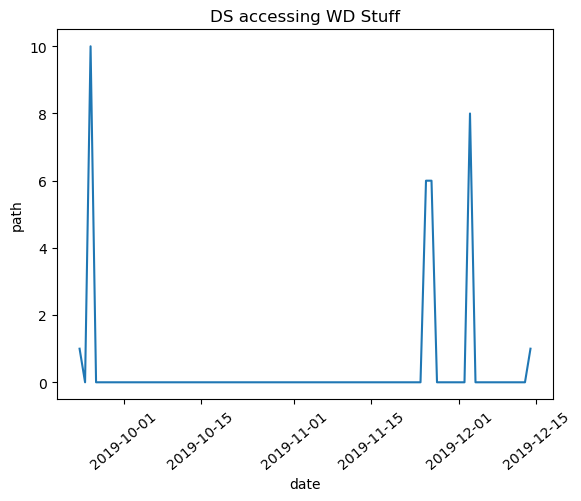

In [32]:
sns.lineplot(x='date', y='path',data=ds_to_wd)
plt.title('DS accessing WD Stuff')
plt.xticks(rotation=40)
plt.show()

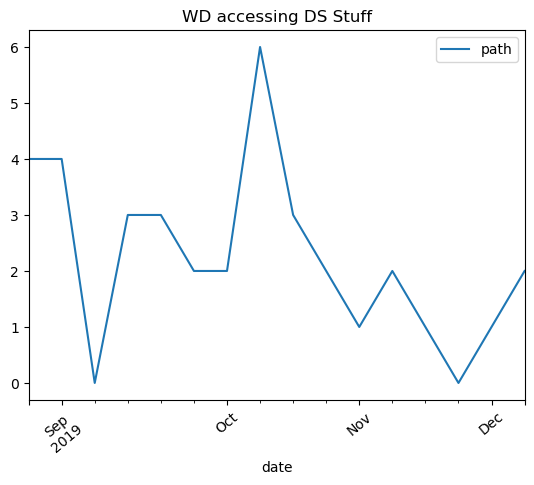

In [33]:
wd_to_ds.path.plot()
plt.title('WD accessing DS Stuff')
plt.xticks(rotation=40)
plt.legend()
plt.show()

In [34]:
# All observations in 2019
twenty_nineteen = df[df['year'] == 2019]

In [35]:
# Data Science and Web Dev data frames
web_dev = twenty_nineteen[(twenty_nineteen['program_id'] == 1) | (twenty_nineteen['program_id'] == 2)]
ds = twenty_nineteen[twenty_nineteen['program_id'] == 3]

In [36]:
# Removing Staff 
ds = ds[ds['name'] != 'Staff']
web_dev = web_dev[web_dev['name'] != 'Staff']

In [41]:
# DS students accessing Java stuff
ds_to_wd = ds[ds['path'].str.contains('java')].resample('w').count()
ds_to_wd

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name,year
datetime,,,,,,,,,,,,,,,,,
2019-09-29,11,11,11,11,11,11,11,11,11,11,11,11,0,11,11,11,11
2019-10-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-10-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-10-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-10-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


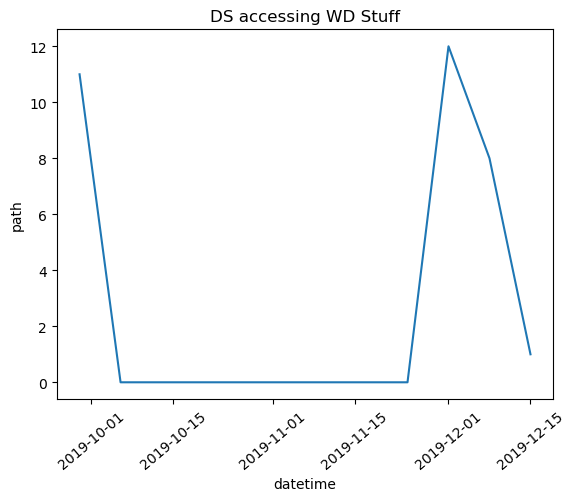

In [48]:
# Lineplot for DS to WD
sns.lineplot(x=ds_to_wd.index, y='path',data=ds_to_wd)
plt.title('DS accessing WD Stuff')
plt.xticks(rotation=40)
plt.show()

In [39]:
# WD students accessing data-scientist stuff
wd_to_ds = web_dev[web_dev['path'].str.contains('data-scientist')].resample('w').count()
wd_to_ds

,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,datetime,ip_name,year
datetime,,,,,,,,,,,,,,,,,
2019-08-25,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4
2019-09-01,4,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4,4
2019-09-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-09-15,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3
2019-09-22,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,2,3
2019-09-29,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
2019-10-06,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,0,2
2019-10-13,6,6,6,6,6,6,6,6,6,6,6,6,0,6,6,5,6
2019-10-20,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,2,3


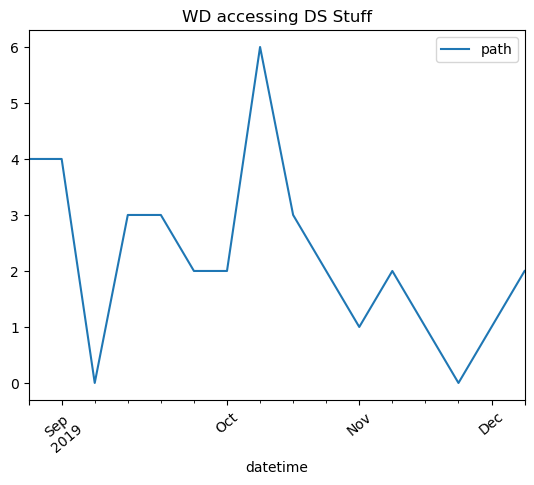

In [40]:
wd_to_ds.path.plot()
plt.title('WD accessing DS Stuff')
plt.xticks(rotation=40)
plt.legend()
plt.show()

In [69]:
def q5(df):
    '''
    Subsets dataframe for only observations in 2019. 
    Removes Staff from observations.
    Resamples data at a weekly rate.
    Plots count of access requests for each program(DS and WD).
    
    Question 5: At some point in 2019, the ability for students and alumni to access 
    both curriculums (web dev to ds, ds to web dev) should have been shut off. 
    Do you see any evidence of that happening? Did it happen before?

    '''
    
    # Year Column
    df['year'] = df.datetime.dt.year
    
    # Set Index
    df = df.set_index(df.datetime)
    
    # All observations in 2019
    twenty_nineteen = df[df['year'] == 2019]
    
    # Data Science and Web Dev data frames
    web_dev = twenty_nineteen[(twenty_nineteen['program_id'] == 1) | (twenty_nineteen['program_id'] == 2)]
    ds = twenty_nineteen[twenty_nineteen['program_id'] == 3]
    
    # Removing Staff 
    ds = ds[ds['name'] != 'Staff']
    web_dev = web_dev[web_dev['name'] != 'Staff']
    
    # DS students accessing Java stuff sampled at a weekly time frame
    ds_to_wd = ds[ds['path'].str.contains('java')].resample('w').count()
    
    # WD students accessing data-scientist stuff at a weekly time frame
    wd_to_ds = web_dev[web_dev['path'].str.contains('data-scientist')].resample('w').count()
    
    # Lineplot for Data Science to Web Dev
    sns.lineplot(x=ds_to_wd.index, y='path',data=ds_to_wd, label='Path')
    plt.title('DS Accessing WD Material 2019')
    plt.xticks(rotation=35)
    plt.ylabel('Number of Requests')
    plt.xlabel('Date')
    plt.legend()
    plt.show()
    
    # Lineplot for Web Dev to Data Science
    sns.lineplot(x=wd_to_ds.index, y='path',data=wd_to_ds, label='Path')
    plt.title('WD Accessing DS Material 2019')
    plt.xticks(rotation=35)
    plt.ylabel('Number of Requests')
    plt.xlabel('Date')
    plt.legend()
    plt.show()


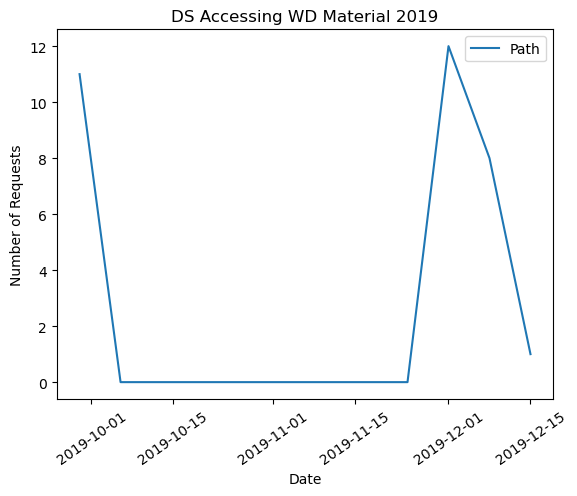

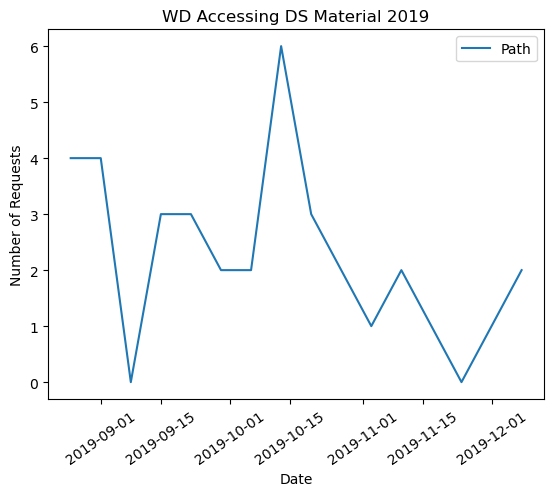

In [70]:
q5(df)

Question 5: At some point in 2019, the ability for students and alumni to access 
    both curriculums (web dev to ds, ds to web dev) should have been shut off. 
    Do you see any evidence of that happening? Did it happen before?
    
   For Web Dev students/alumni accessing Data Science material, there are two particular points in the graph that sparks interest. September 8 and November 24. On both these days, there were no data science material accessed. Trying to compare it the other way around with DS students/alumni accessing Web Dev material leaves much to be desired when investigating. DS data does not start till September 29, so I am unable to compare it to the September 8 data for Web Dev. Also, DS students/alumni did not access any Web Dev material from Oct 06 to Dec 01. 
   It is possible that Data Science students never had access denied to Web Dev material. 
   It is possible that Web Dev had access cut off to them in September and November.